# Yosia Letare Banurea
#121450149
#RA

## A Dataset to Play With

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import numpy as np
import pickle
from pathlib import Path

# Path to the unzipped CIFAR data
data_dir = Path("/content/drive/MyDrive/cifar-10-batches-py")

# Unpickle function provided by the CIFAR hosts
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

images, labels = [], []
for batch in data_dir.glob("data_batch_*"):
    batch_data = unpickle(batch)
    for i, flat_im in enumerate(batch_data[b"data"]):
        im_channels = []
        # Each image is flattened, with channels in order of R, G, B
        for j in range(3):
            im_channels.append(
                flat_im[j * 1024 : (j + 1) * 1024].reshape((32, 32))
            )
        # Reconstruct the original image
        images.append(np.dstack((im_channels)))
        # Save the label
        labels.append(batch_data[b"labels"][i])

print("Loaded CIFAR-10 training set:")
print(f" - np.shape(images)     {np.shape(images)}")
print(f" - np.shape(labels)     {np.shape(labels)}")

Loaded CIFAR-10 training set:
 - np.shape(images)     (50000, 32, 32, 3)
 - np.shape(labels)     (50000,)



Kode di atas digunakan untuk membaca dataset CIFAR-10. Dataset ini terdiri dari 50.000 gambar berwarna dengan resolusi 32x32 piksel, yang terbagi dalam 10 kelas. Pertama, modul-modul yang diperlukan diimpor, termasuk numpy untuk operasi numerik, pickle untuk membaca file pickle, dan Path dari pathlib untuk bekerja dengan path file. Selanjutnya, dataset CIFAR-10 yang telah diunggah ke Google Drive diakses melalui drive.mount('/content/drive') untuk mengaitkan Google Drive dengan Colab. Fungsi unpickle kemudian dibuat untuk membaca file pickle CIFAR-10. Setiap batch data CIFAR-10 dibaca dan direkonstruksi menjadi gambar berwarna penuh dari 3 kanal warna (R, G, B). Informasi tentang data yang telah dimuat, termasuk bentuk array gambar dan label, ditampilkan. Penting untuk dicatat bahwa kode ini ditulis untuk dijalankan di Google Colab dan mungkin memerlukan penyesuaian jika ingin dijalankan di lingkungan lokal.

## Storing a Single Image

In [34]:
from pathlib import Path

disk_dir = Path("data/disk/")
lmdb_dir = Path("data/lmdb/")
hdf5_dir = Path("data/hdf5/")

In [35]:
disk_dir.mkdir(parents=True, exist_ok=True)
lmdb_dir.mkdir(parents=True, exist_ok=True)
hdf5_dir.mkdir(parents=True, exist_ok=True)

Code ini untuk membuat struktur direktori penyimpanan data dalam tiga format berbeda: disk, LMDB (Lightning Memory-Mapped Database), dan HDF5 (Hierarchical Data Format version 5). Pertama, modul Path dari pathlib diimpor untuk memungkinkan manipulasi path file. Selanjutnya, tiga objek Path dibuat untuk mewakili direktori penyimpanan untuk masing-masing format: disk_dir untuk penyimpanan di disk, lmdb_dir untuk LMDB, dan hdf5_dir untuk HDF5. Kemudian, metode mkdir(parents=True, exist_ok=True) digunakan untuk membuat direktori-direktori tersebut. Argumen parents=True digunakan agar direktori induk juga dibuat jika belum ada, sedangkan exist_ok=True memastikan bahwa pembuatan direktori tidak akan menyebabkan exception jika direktori tersebut sudah ada. Tujuan dari kode ini adalah untuk menyiapkan struktur direktori penyimpanan yang akan digunakan untuk menyimpan data dalam berbagai format, seperti gambar, data numerik, atau data lainnya, untuk keperluan pengolahan data

## Storing to Disk

In [36]:
from PIL import Image
import csv

def store_single_disk(image, image_id, label):
    """ Stores a single image as a .png file on disk.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    Image.fromarray(image).save(disk_dir / f"{image_id}.png")

    with open(disk_dir / f"{image_id}.csv", "wt") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        writer.writerow([label])

##Storing to LMDB

In [37]:
class CIFAR_Image:
    def __init__(self, image, label):
        # Dimensions of image for reconstruction - not really necessary
        # for this dataset, but some datasets may include images of
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]

        self.image = image.tobytes()
        self.label = label

    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)

In [38]:
#!pip install lmdb

In [39]:
import lmdb
import pickle

def store_single_lmdb(image, image_id, label):
    """ Stores a single image to a LMDB.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    map_size = image.nbytes * 10

    # Create a new LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), map_size=map_size)

    # Start a new write transaction
    with env.begin(write=True) as txn:
        # All key-value pairs need to be strings
        value = CIFAR_Image(image, label)
        key = f"{image_id:08}"
        txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

Code ini untuk menyimpan gambar dan labelnya ke dalam disk dalam format yang berbeda. Fungsi store_single_disk menerima tiga parameter: image yang merupakan array gambar dengan dimensi (32, 32, 3), image_id yang merupakan ID unik untuk gambar tersebut, dan label yang merupakan label gambar.

Dengan menggunakan fungsi modul PIL untuk mengakses fungsi Image yang memungkinkan penyimpanan gambar dalam format PNG. Gambar disimpan ke dalam disk dengan menggunakan Image.fromarray(image).save(disk_dir / f"{image_id}.png"), di mana disk_dir / f"{image_id}.png" adalah path lengkap untuk menyimpan gambar.

Selanjutnya, fungsi membuat file CSV untuk menyimpan label gambar. Fungsi csv.writer digunakan untuk menulis label ke dalam file CSV. Label ditulis ke dalam file dengan nama yang sama dengan ID gambar namun dengan ekstensi CSV ({image_id}.csv).

Dengan fungsi store_single_disk, pengguna dapat dengan mudah menyimpan sebuah gambar ke dalam disk beserta labelnya dalam format yang sesuai.








##Storing With HDF5

In [40]:
import h5py

def store_single_hdf5(image, image_id, label):
    """ Stores a single image to an HDF5 file.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "image", np.shape(image), h5py.h5t.STD_U8BE, data=image
    )
    meta_set = file.create_dataset(
        "meta", np.shape(label), h5py.h5t.STD_U8BE, data=label
    )
    file.close()

Pada Bagian ini untuk menyimpan sebuah gambar beserta labelnya ke dalam sebuah file HDF5. Fungsi store_single_hdf5 menerima tiga parameter: image yang merupakan array gambar dengan dimensi (32, 32, 3), image_id yang merupakan ID unik untuk gambar tersebut, dan label yang merupakan label gambar.

Pertama, fungsi menggunakan modul h5py untuk membuat dan berinteraksi dengan file HDF5. Fungsi h5py.File digunakan untuk membuat file HDF5 baru dengan nama file yang ditentukan (hdf5_dir / f"{image_id}.h5").

Selanjutnya, dua dataset dibuat di dalam file HDF5: satu untuk data gambar ("image") dan satu untuk label ("meta"). Metode create_dataset digunakan untuk tujuan ini, dengan menentukan nama dataset, bentuk, tipe data (h5py.h5t.STD_U8BE untuk data unsigned 8-bit), dan data yang akan disimpan.

Terakhir, file HDF5 ditutup dengan menggunakan file.close(). Dengan menggunakan fungsi store_single_hdf5, pengguna dapat dengan mudah menyimpan sebuah gambar beserta labelnya ke dalam sebuah file HDF5 untuk keperluan pengolahan data atau pembelajaran mesin.








##Experiments for Storing a Single Image

In [41]:
_store_single_funcs = dict(
    disk=store_single_disk, lmdb=store_single_lmdb, hdf5=store_single_hdf5
)

In [42]:
from timeit import timeit

store_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_store_single_funcs[method](image, 0, label)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    store_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.028307739999945625
Method: lmdb, Time usage: 0.009082840999781183
Method: hdf5, Time usage: 0.005928252999638062


Code ini untuk membandingkan waktu yang dibutuhkan untuk menyimpan sebuah gambar beserta labelnya ke dalam disk, LMDB, dan file HDF5. Pertama, sebuah kamus _store_single_funcs dibuat untuk menyimpan fungsi-fungsi yang digunakan untuk menyimpan gambar ke dalam masing-masing format.

Selanjutnya, menggunakan modul timeit, waktu eksekusi dari setiap metode penyimpanan diukur untuk gambar pertama dalam dataset. Loop for digunakan untuk melakukan pengukuran untuk setiap metode penyimpanan.

Hasil dari eksperimen ini menunjukkan bahwa penyimpanan menggunakan file HDF5 (hdf5) memiliki waktu eksekusi yang paling cepat, diikuti oleh LMDB (lmdb), dan yang paling lambat adalah penyimpanan ke dalam disk (disk). Hal ini menunjukkan bahwa pemilihan format penyimpanan dapat mempengaruhi kinerja aplikasi, terutama dalam hal waktu yang dibutuhkan untuk operasi penyimpanan dan pengambilan data. Dengan memahami karakteristik dari masing-masing format penyimpanan, pengembang dapat memilih format yang paling sesuai untuk kebutuhan aplikasi mereka.








##Storing Many Images

In [43]:
def store_many_disk(images, labels):
    """ Stores an array of images to disk
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Save all the images one by one
    for i, image in enumerate(images):
        Image.fromarray(image).save(disk_dir / f"{i}.png")

    # Save all the labels to the csv file
    with open(disk_dir / f"{num_images}.csv", "w") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for label in labels:
            # This typically would be more than just one value per row
            writer.writerow([label])

def store_many_lmdb(images, labels):
    """ Stores an array of images to LMDB.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    map_size = num_images * images[0].nbytes * 10

    # Create a new LMDB DB for all the images
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), map_size=map_size)

    # Same as before — but let's write all the images in a single transaction
    with env.begin(write=True) as txn:
        for i in range(num_images):
            # All key-value pairs need to be Strings
            value = CIFAR_Image(images[i], labels[i])
            key = f"{i:08}"
            txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

def store_many_hdf5(images, labels):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    meta_set = file.create_dataset(
        "meta", np.shape(labels), h5py.h5t.STD_U8BE, data=labels
    )
    file.close()

Code ini merupakan implementasi fungsi-fungsi untuk menyimpan banyak gambar beserta labelnya ke dalam disk, LMDB, dan file HDF5. Berikut adalah penjelasan singkat tentang setiap fungsi:

* store_many_disk(images, labels): Fungsi ini menyimpan array gambar ke dalam disk dalam format PNG, satu gambar per file. Selain itu, label-label dari gambar disimpan dalam satu file CSV.
* store_many_lmdb(images, labels): Fungsi ini menyimpan array gambar ke dalam database LMDB. LMDB digunakan karena efisiensinya dalam menyimpan data biner besar seperti gambar. Setiap gambar disimpan dengan kunci unik dalam format string, dan label-label disimpan bersama dengan gambar dalam format objek CIFAR_Image yang kemudian di-serialize menggunakan pickle.
* store_many_hdf5(images, labels): Fungsi ini menyimpan array gambar ke dalam file HDF5. HDF5 digunakan karena kemampuannya untuk menyimpan data multidimensional dalam bentuk dataset. Setiap dataset dalam file HDF5 berisi array gambar atau label-label.


Ketiga fungsi ini memungkinkan penyimpanan efisien dari banyak gambar bersama dengan labelnya dalam berbagai format penyimpanan

##Preparing the Dataset

In [44]:
cutoffs = [10, 100, 1000, 10000, 100000]

# Let's double our images so that we have 100,000
images = np.concatenate((images, images), axis=0)
labels = np.concatenate((labels, labels), axis=0)

# Make sure you actually have 100,000 images and labels
print(np.shape(images))
print(np.shape(labels))

(100000, 32, 32, 3)
(100000,)


Code ini digunakan untuk mempersiapkan sebuah dataset dengan jumlah data yang cukup besar untuk pelatihan model. Pertama-tama, ada definisi dari variabel cutoffs yang menentukan batas jumlah data yang ingin dimiliki. Kemudian, terdapat perintah untuk menggandakan jumlah gambar dalam dataset hingga mencapai 100,000. Proses penggandaan ini dilakukan dengan menggunakan fungsi np.concatenate, yang menggabungkan array images dan labels ke dalam diri mereka sendiri. Ini dilakukan dengan menggabungkan array itu sendiri dengan sumbu 0 (axis=0), artinya data baru akan ditambahkan di baris baru setelah data yang sudah ada. Setelah penambahan data, dilakukan pencetakan bentuk dari array images dan labels untuk memastikan bahwa jumlah data telah mencapai target 100,000. Hasil cetakan menunjukkan bahwa bentuk array images adalah (100000, 32, 32, 3), yang menandakan bahwa terdapat 100,000 gambar dengan dimensi 32x32 pixel dan tiga saluran warna (RGB), sementara bentuk array labels adalah (100000,), menunjukkan bahwa terdapat 100,000 label yang sesuai dengan gambar-gambar tersebut. Dengan demikian, dataset telah berhasil disiapkan dengan jumlah data yang diinginkan.

##Experiment for Storing Many Images

In [45]:
_store_many_funcs = dict(
    disk=store_many_disk, lmdb=store_many_lmdb, hdf5=store_many_hdf5
)

from timeit import timeit

store_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_store_many_funcs[method](images_, labels_)",
            setup="images_=images[:cutoff]; labels_=labels[:cutoff]",
            number=1,
            globals=globals(),
        )
        store_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.007747186999949918
Method: lmdb, Time usage: 0.008566558999973495
Method: hdf5, Time usage: 0.0031104939998840564
Method: disk, Time usage: 0.04572852799992688
Method: lmdb, Time usage: 0.02515209400007734
Method: hdf5, Time usage: 0.003519635999964521
Method: disk, Time usage: 0.48345337399996424
Method: lmdb, Time usage: 0.042777183999987756
Method: hdf5, Time usage: 0.006078934000015579
Method: disk, Time usage: 5.264483131999896
Method: lmdb, Time usage: 0.4975929110000834
Method: hdf5, Time usage: 0.03036241900008463
Method: disk, Time usage: 47.06680086000006
Method: lmdb, Time usage: 4.210487470999851
Method: hdf5, Time usage: 0.766715774000204


untuk menyimpan banyak gambar menggunakan tiga metode penyimpanan yang berbeda: disk, LMDB (Lightning Memory-Mapped Database), dan HDF5 (Hierarchical Data Format version 5). Pertama-tama, terdapat definisi dictionary _store_many_funcs yang memetakan nama metode penyimpanan ke fungsi yang sesuai untuk setiap metode. Kemudian, dilakukan import dari modul timeit untuk mengukur waktu eksekusi kode. Hasil pengukuran waktu penyimpanan untuk setiap metode dan jumlah data tertentu disimpan dalam dictionary store_many_timings.

Selanjutnya, dilakukan iterasi melalui nilai-nilai dalam cutoffs, yang menentukan jumlah data yang akan digunakan dalam setiap iterasi. Di dalam iterasi ini, setiap metode penyimpanan (disk, LMDB, HDF5) dijalankan untuk menyimpan data sebanyak cutoff gambar. Pengukuran waktu dilakukan dengan menggunakan fungsi timeit, yang menjalankan fungsi penyimpanan sekali saja dengan parameter-parameter yang diberikan dalam setup. Waktu eksekusi kemudian dicatat dan disimpan dalam dictionary store_many_timings sesuai dengan metode penyimpanan yang digunakan.

Hasil output menunjukkan waktu eksekusi untuk setiap metode penyimpanan dan setiap nilai cutoff yang digunakan dalam eksperimen. Dapat diamati bahwa waktu eksekusi meningkat seiring dengan peningkatan jumlah data yang disimpan, dan juga berbeda-beda antara metode penyimpanan. Metode penyimpanan disk membutuhkan waktu paling lama, sementara LMDB dan HDF5 cenderung lebih cepat, terutama saat jumlah data semakin besar. Hal ini menunjukkan bahwa pemilihan metode penyimpanan dapat memengaruhi kinerja dan waktu eksekusi dalam menyimpan banyak gambar.

<ipython-input-46-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


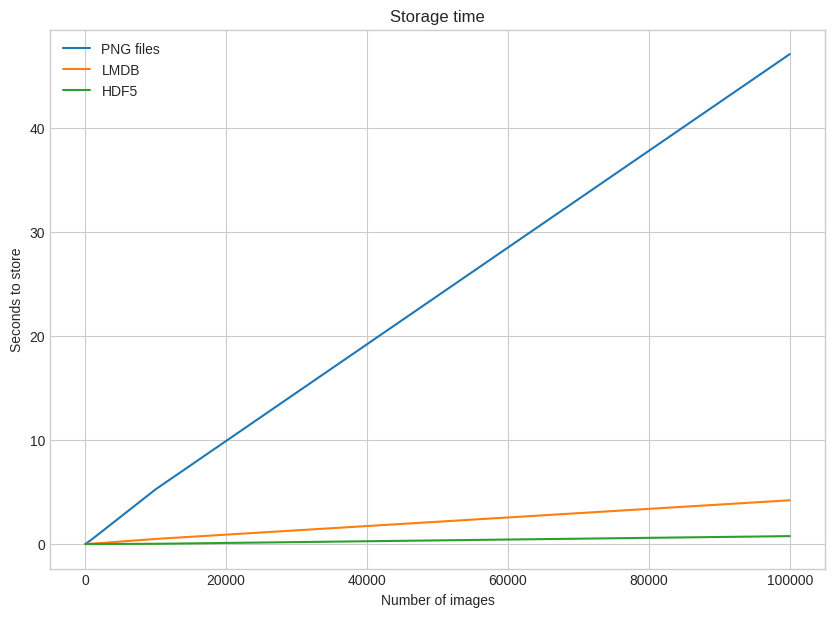

<ipython-input-46-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


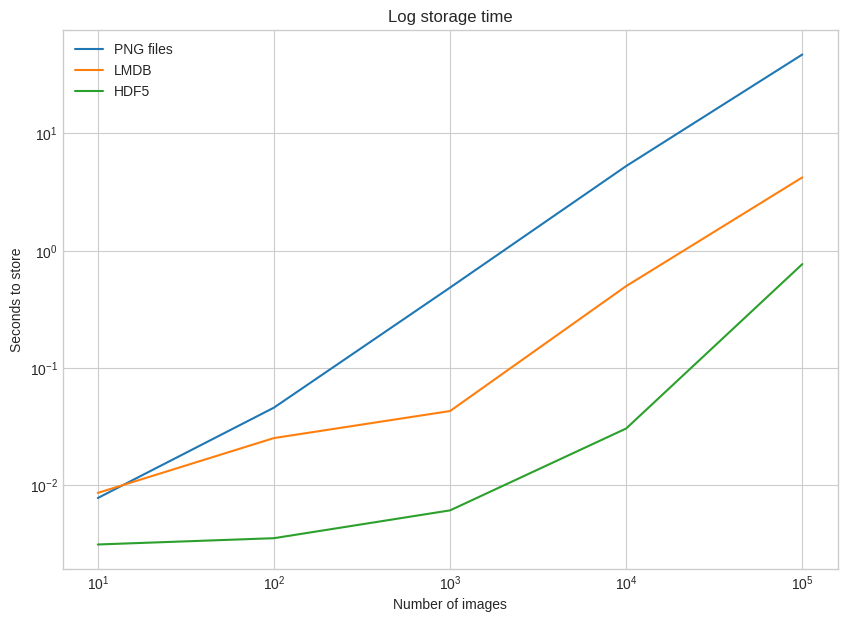

In [46]:
import matplotlib.pyplot as plt

def plot_with_legend(
    x_range, y_data, legend_labels, x_label, y_label, title, log=False
):
    """ Displays a single plot with multiple datasets and matching legends.
        Parameters:
        --------------
        x_range         list of lists containing x data
        y_data          list of lists containing y values
        legend_labels   list of string legend labels
        x_label         x axis label
        y_label         y axis label
    """
    plt.style.use("seaborn-whitegrid")
    plt.figure(figsize=(10, 7))

    if len(y_data) != len(legend_labels):
        raise TypeError(
            "Error: number of data sets does not match number of labels."
        )

    all_plots = []
    for data, label in zip(y_data, legend_labels):
        if log:
            temp, = plt.loglog(x_range, data, label=label)
        else:
            temp, = plt.plot(x_range, data, label=label)
        all_plots.append(temp)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(handles=all_plots)
    plt.show()

# Getting the store timings data to display
disk_x = store_many_timings["disk"]
lmdb_x = store_many_timings["lmdb"]
hdf5_x = store_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Storage time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Log storage time",
    log=True,
)

Dari grafik tersebut,dapat dilihat bahwa menyimpan gambar dalam file PNG adalah metode yang paling lambat. Menyimpan gambar dalam LMDB dan HDF5 jauh lebih cepat. Untuk sejumlah kecil gambar, HDF5 sedikit lebih cepat daripada LMDB. Namun, untuk jumlah gambar yang lebih besar, LMDB menjadi lebih cepat daripada HDF5. Secara keseluruhan, LMDB tampaknya menjadi cara paling efisien untuk menyimpan sejumlah besar gambar dari ketiga metode yang ditampilkan dalam grafik.

##Reading a Single Image

###Reading From Disk

In [47]:
def read_single_disk(image_id):
    """ Stores a single image to disk.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    image = np.array(Image.open(disk_dir / f"{image_id}.png"))

    with open(disk_dir / f"{image_id}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        label = int(next(reader)[0])

    return image, label

Untuk metode pembacaan dari disk, terdapat fungsi read_single_disk(image_id) yang menerima parameter image_id, yang merupakan ID unik untuk gambar yang ingin dibaca. Fungsi ini membuka gambar dari file PNG dengan menggunakan modul Image dari library PIL (Python Imaging Library). Selain itu, label terkait dibaca dari file CSV yang memiliki format sederhana dengan menggunakan modul csv. Fungsi mengembalikan gambar dan label tersebut.

###Reading From LMDB

In [48]:
def read_single_lmdb(image_id):
    """ Stores a single image to LMDB.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Encode the key the same way as we stored it
        data = txn.get(f"{image_id:08}".encode("ascii"))
        # Remember it's a CIFAR_Image object that is loaded
        cifar_image = pickle.loads(data)
        # Retrieve the relevant bits
        image = cifar_image.get_image()
        label = cifar_image.label
    env.close()

    return image, label

Untuk metode pembacaan dari LMDB, ada fungsi read_single_lmdb(image_id) yang juga menerima parameter image_id. Fungsi ini membuka lingkungan LMDB menggunakan modul lmdb dan memulai transaksi baca. Data gambar dan label yang sesuai dengan image_id diambil dari transaksi tersebut. Gambar didekode dari objek CIFAR_Image yang telah disimpan menggunakan pickle, sedangkan label diambil langsung dari objek CIFAR_Image. Setelah itu, lingkungan LMDB ditutup dan gambar serta label dikembalikan.

###Reading From HDF5

In [49]:
def read_single_hdf5(image_id):
    """ Stores a single image to HDF5.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "r+")

    image = np.array(file["/image"]).astype("uint8")
    label = int(np.array(file["/meta"]).astype("uint8"))

    return image, label

Untuk metode pembacaan dari HDF5, terdapat fungsi read_single_hdf5(image_id) yang juga menerima image_id sebagai parameter. Fungsi ini membuka file HDF5 menggunakan modul h5py. Data gambar dan label diambil dari dataset yang sesuai di dalam file HDF5. Gambar dibaca dari dataset bernama "/image", sementara label dibaca dari dataset bernama "/meta". Data gambar dan label dikembalikan setelah dibaca.

In [50]:
_read_single_funcs = dict(
    disk=read_single_disk, lmdb=read_single_lmdb, hdf5=read_single_hdf5
)

Dictionary _read_single_funcs digunakan untuk memetakan nama metode penyimpanan ke fungsi pembacaannya masing-masing. Dengan demikian, fungsi-fungsi ini memungkinkan penggunaan yang fleksibel tergantung pada metode penyimpanan yang digunakan dalam dataset.

###Experiment for Reading a Single Image

In [51]:
from timeit import timeit

read_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_read_single_funcs[method](0)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    read_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.00372383500007345
Method: lmdb, Time usage: 0.00039023399995130603
Method: hdf5, Time usage: 0.00501866299964604


code ini digunakan untuk mengukur waktu pembacaan sebuah gambar tunggal dan label terkait dari tiga metode penyimpanan yang berbeda: disk, LMDB (Lightning Memory-Mapped Database), dan HDF5 (Hierarchical Data Format version 5).

Hasil output menunjukkan waktu eksekusi untuk pembacaan sebuah gambar tunggal dan label terkait dari setiap metode penyimpanan. Dapat dilihat bahwa waktu eksekusi bervariasi antara metode-metode tersebut. Pembacaan dari LMDB (0.0003902 detik) merupakan yang paling cepat, diikuti oleh pembacaan dari disk (0.0037238 detik), dan yang terakhir adalah pembacaan dari HDF5 (0.0050187 detik). Hal ini menunjukkan bahwa pembacaan dari LMDB memiliki kinerja yang lebih cepat dibandingkan dengan metode pembacaan dari disk dan HDF5 untuk kasus pembacaan sebuah gambar tunggal.








##Reading Many Images

###Adjusting the Code for Many Images

In [52]:
def read_many_disk(num_images):
    """ Reads image from disk.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Loop over all IDs and read each image in one by one
    for image_id in range(num_images):
        images.append(np.array(Image.open(disk_dir / f"{image_id}.png")))

    with open(disk_dir / f"{num_images}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for row in reader:
            labels.append(int(row[0]))
    return images, labels

def read_many_lmdb(num_images):
    """ Reads image from LMDB.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Read all images in one single transaction, with one lock
        # We could split this up into multiple transactions if needed
        for image_id in range(num_images):
            data = txn.get(f"{image_id:08}".encode("ascii"))
            # Remember that it's a CIFAR_Image object
            # that is stored as the value
            cifar_image = pickle.loads(data)
            # Retrieve the relevant bits
            images.append(cifar_image.get_image())
            labels.append(cifar_image.label)
    env.close()
    return images, labels

def read_many_hdf5(num_images):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "r+")

    images = np.array(file["/images"]).astype("uint8")
    labels = np.array(file["/meta"]).astype("uint8")

    return images, labels

_read_many_funcs = dict(
    disk=read_many_disk, lmdb=read_many_lmdb, hdf5=read_many_hdf5
)


Kode di atas mengadaptasi fungsi pembacaan untuk membaca banyak gambar sekaligus dari tiga metode penyimpanan yang berbeda: disk, LMDB, dan HDF5. Fungsi read_many_disk(num_images) membaca gambar dan label dari file PNG dan CSV, masing-masing, untuk setiap ID gambar dalam rentang yang ditentukan. Fungsi read_many_lmdb(num_images) membaca data dari lingkungan LMDB dalam satu transaksi, dengan mengambil gambar dan label yang sesuai untuk setiap ID gambar. Sedangkan fungsi read_many_hdf5(num_images) membaca data dari file HDF5, dengan mengambil gambar dan label dari dataset yang sesuai. Semua fungsi mengembalikan array gambar dan label untuk jumlah gambar yang ditentukan. Dictionary _read_many_funcs memetakan nama metode penyimpanan ke fungsi pembacaannya, memberikan fleksibilitas dalam penggunaan tergantung pada metode penyimpanan yang digunakan dalam dataset.

###Experiment for Reading Many Images

In [53]:
from timeit import timeit

read_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_read_many_funcs[method](num_images)",
            setup="num_images=cutoff",
            number=1,
            globals=globals(),
        )
        read_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, No. images: {cutoff}, Time usage: {t}")

Method: disk, No. images: 10, Time usage: 0.004969050999989122
Method: lmdb, No. images: 10, Time usage: 0.0006435410000449338
Method: hdf5, No. images: 10, Time usage: 0.002334582000003138
Method: disk, No. images: 100, Time usage: 0.06459547200029192
Method: lmdb, No. images: 100, Time usage: 0.002678989999822079
Method: hdf5, No. images: 100, Time usage: 0.002453051999964373
Method: disk, No. images: 1000, Time usage: 0.4039130340001975
Method: lmdb, No. images: 1000, Time usage: 0.02127163399973142
Method: hdf5, No. images: 1000, Time usage: 0.005680773999756639
Method: disk, No. images: 10000, Time usage: 3.316332723999949
Method: lmdb, No. images: 10000, Time usage: 0.13784933700026158
Method: hdf5, No. images: 10000, Time usage: 0.03202942300003997
Method: disk, No. images: 100000, Time usage: 30.005195590000312
Method: lmdb, No. images: 100000, Time usage: 1.3953561759999502
Method: hdf5, No. images: 100000, Time usage: 0.8875100769996607


code ini digunakan untuk mengukur waktu pembacaan banyak gambar sekaligus dari tiga metode penyimpanan yang berbeda: disk, LMDB (Lightning Memory-Mapped Database), dan HDF5 (Hierarchical Data Format version 5). Dalam eksperimen ini, terdapat nested loop yang mengiterasi melalui nilai-nilai dalam variabel cutoffs, yang menentukan jumlah gambar yang akan dibaca dalam setiap iterasi. Di dalam setiap iterasi tersebut, juga terdapat loop yang mengiterasi melalui metode-metode penyimpanan yang ada. Setiap metode penyimpanan dijalankan untuk membaca jumlah gambar yang ditentukan, dan waktu eksekusi untuk pembacaan tersebut diukur menggunakan fungsi timeit. Hasil pengukuran waktu pembacaan untuk setiap metode penyimpanan dan jumlah gambar tertentu dicatat dalam dictionary read_many_timings. Output dari eksperimen ini menunjukkan bahwa waktu pembacaan meningkat seiring dengan peningkatan jumlah gambar yang dibaca, dan berbeda-beda antara metode-metode penyimpanan. Metode pembacaan dari LMDB cenderung memiliki kinerja yang lebih cepat dibandingkan dengan metode pembacaan dari disk dan HDF5, terutama saat jumlah gambar semakin besar. Sedangkan, metode pembacaan dari HDF5 menunjukkan waktu eksekusi yang lebih baik dibandingkan dengan metode pembacaan dari disk saat jumlah gambar mencapai 100,000. Hal ini menunjukkan bahwa performa pembacaan banyak gambar tergantung pada jenis penyimpanan yang digunakan, dan pilihan metode penyimpanan dapat memengaruhi waktu eksekusi pembacaan data.